In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram

import Ipynb_importer

In [3]:
import step3_geomery_based_clustering as gbc

In [4]:
trajectory = np.loadtxt('data/trajectory_in_week_3ptype_2019_58.txt')

In [5]:
# 数据转化：保留活动的起始点和终止点
def extract_se(trajectory):
    Point_clouds = []
    Point_clouds.append([0,trajectory[0]*100])
    Point_clouds.append([len(trajectory)-1,trajectory[-1]*100])
    
    for i in range(1,len(trajectory)):
        if trajectory[i]!=trajectory[i-1]:
            Point_clouds.append([i-1,trajectory[i-1]*100])
            Point_clouds.append([i,trajectory[i]*100])
    
    return np.array(Point_clouds)        
        

In [6]:
trajectory_sim = []
for data in trajectory:
    trajectory_10min = gbc.simplify_seq(data)
    trajectory_se = extract_se(trajectory_10min)
    trajectory_sim.append(trajectory_se)

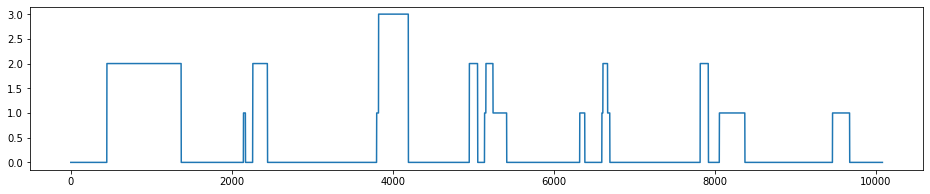

In [27]:
plt.figure(figsize=(16,3))
plt.plot(trajectory[0])

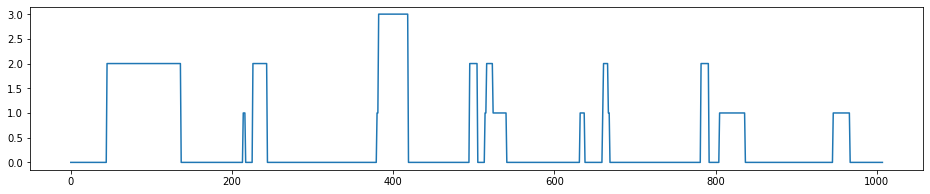

In [21]:
plt.figure(figsize=(16,3))
plt.plot(trajectory_10min)

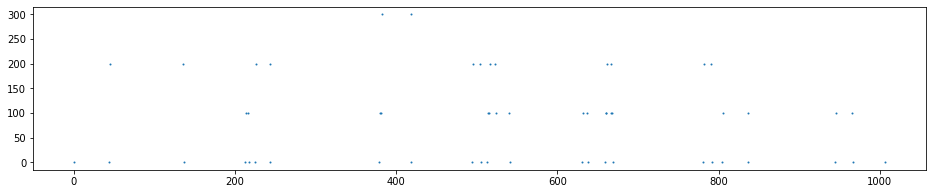

In [31]:
plt.figure(figsize=(16,3))
plt.scatter(trajectory_sim[0][:,0],trajectory_sim[0][:,1],s=1)

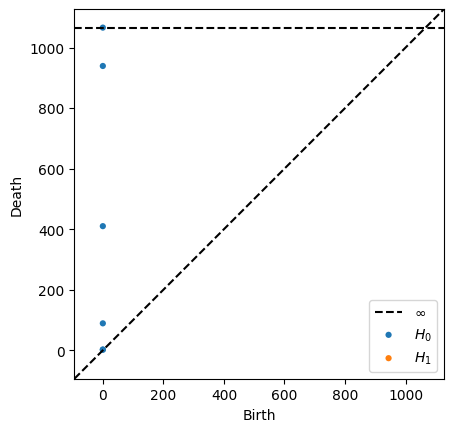

In [32]:
# persitent homology
#act_data=np.array([[0,0],[410,0],[411,2],[1350,2],[1351,0],[1440,0]])
ripser_complex = ripser(act_data)
plot_diagrams(ripser_complex['dgms'], show=True)

In [33]:
ripser_complex['dgms']

[array([[  0.        ,   2.23606801],
        [  0.        ,   2.23606801],
        [  0.        ,  89.        ],
        [  0.        , 410.        ],
        [  0.        , 939.        ],
        [  0.        ,          inf]]),
 array([], shape=(0, 2), dtype=float64)]

In [26]:
# define a barcodes drawing function
# copied from github.
"""
  Fuction for plotting barcode diagrams
  
  Input:
    diagrams: result of rips.fit_transform
    dimension: dimension for which the barcodes will be plotted
    colors: color of bars
    line_width: width of bars
    title: tile of graph
  
  Output:
    a matplotlib graph
  """

def plot_barcodes(diagrams,dimension=0,colors='grey',line_width=2,title=None):
    if (title is None):
        title="Dimension "+str(dimension)
    
    barcodes=pd.DataFrame(diagrams[dimension],columns=['start','end'])
    fig, ax = plt.subplots()
    plt.hlines(y=list(barcodes.index), xmin=list(barcodes.start), xmax=list(barcodes.end), colors=colors, lw=line_width, label=title)
    plt.legend(loc='lower right')
    plt.show()

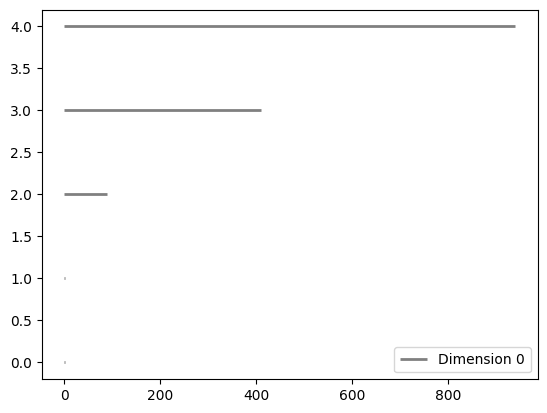

In [34]:
plot_barcodes(ripser_complex['dgms'])

In [38]:
Persistence_Diagrams = []
for index,data in enumerate(trajectory_sim):
    X= data.reshape(1,*data.shape)
    VR = VietorisRipsPersistence(homology_dimensions=[0, 1])  # Parameter explained in the text
    diagrams = VR.fit_transform(X)
    Persistence_Diagrams.append(diagrams)
    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
plot_diagram(Persistence_Diagrams[0][0])

NameError: name 'Persistence_Diagrams' is not defined

## 提取持续同调图特征

### 构建特征提取pipeline

In [44]:
from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration
from gtda.diagrams import Amplitude

In [46]:
#Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

#
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

# tda_union = make_union(
#     *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
#     n_jobs=-1
# )

In [54]:
Features = []
for index,data in enumerate(Persistence_Diagrams):
    feature = feature_union.fit_transform(data)
    Features.append(feature)
    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


KeyboardInterrupt: 

In [53]:
Features[0].shape

(1, 28)